# PPAC Analysis Notebook

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Load Data

In [2]:
data_dir = 'correlations/test'
data_paths = {
    "coincident": Path(f"{data_dir}/coincident_imp.pkl"),
    "decay_candidates": Path(f"{data_dir}/decay_candidates.pkl"),
    "final_correlated": Path(f"{data_dir}/final_correlated.pkl"),
}
data = {}
for name, path in data_paths.items():
    if path.exists():
        data[name] = pd.read_pickle(path)
        print(f"Loaded {name}: {len(data[name])} rows")
    else:
        print(f"File {path} not found")

Loaded coincident: 181177 rows
Loaded decay_candidates: 26154 rows
Loaded final_correlated: 3571 rows


## Basic Inspection

In [3]:
for name, df in data.items():
    display(df.head())

,imp_timetag,imp_x,imp_y,imp_tagx,imp_tagy,imp_nfile,imp_tdelta,imp_nX,imp_nY,imp_xE,...,dt_anodeH_ps,dt_cathode_ns,dt_anodeV_ns,dt_anodeH_ns,dt_cathode_us,dt_anodeV_us,dt_anodeH_us,dt_anodeH_us_corr,dt_anodeV_us_corr,dt_cathode_us_corr
0,198634810650,9,50,198634810650,198634760742,0,49908,1,1,6782.193936,...,-1430192,-1423.496,-1431.597,-1430.192,-1.423496,-1.431597,-1.430192,-1.430192,-1.431597,-1.423496
1,529691550542,147,12,529691550542,529691391264,0,159278,1,1,38852.690963,...,-1507289,-1502.885,-1508.120,-1507.289,-1.502885,-1.508120,-1.507289,-1.507289,-1.508120,-1.502885
2,912400550245,18,11,912400550245,912400538374,0,11871,1,1,2687.152713,...,-1424942,-1417.065,-1422.994,-1424.942,-1.417065,-1.422994,-1.424942,-1.424942,-1.422994,-1.417065
3,916484660872,40,19,916484660872,916484657870,0,3002,1,1,2320.956539,...,-1427958,-1421.015,-1425.733,-1427.958,-1.421015,-1.425733,-1.427958,-1.427958,-1.425733,-1.421015
4,974031403169,29,3,974031403169,974031360827,0,42342,1,1,13223.659695,...,-1421801,-1416.924,-1424.154,-1421.801,-1.416924,-1.424154,-1.421801,-1.421801,-1.424154,-1.416924


,t,x,y,tagx,tagy,nfile,xboard,yboard,tdelta,nX,nY,xE,yE,event_type,recoil_index,recoil_time_sec,ppac_flag,is_clean,log_dt
0,2.839951,147,12,2839951104007,2839951009995,0,0,7,94012,1,1,333.187114,416.077084,imp,1,0.529692,both,False,0.837360
1,20.860982,29,3,20860982345999,20860982277992,0,4,6,68007,1,1,328.327655,386.433508,imp,4,0.974031,both,False,2.990064
2,6.790124,37,22,6790123589371,6790123537373,0,4,7,51998,1,1,2623.933228,2641.425231,imp,6,1.142596,both,False,1.731218
3,1.718427,137,45,1718426961995,1718426873998,0,0,6,87997,1,1,340.905662,338.431080,imp,10,1.445411,both,False,-1.298225
4,13.175558,152,33,13175557948998,13175557849998,0,1,6,99000,1,1,400.480785,385.106297,imp,13,1.527234,both,False,2.455162


,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha1_x,alpha1_y,alpha1_t,alpha1_xE,alpha1_dt,alpha2_x,alpha2_y,alpha2_t,alpha2_xE,alpha2_dt
0,35.0,15.0,6862.952065,6.046224e+13,6.046224e+13,4042.0,6.046224e+13,920.0,6.046224e+13,1389.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,87.0,26.0,4388.934390,9.344928e+13,9.344928e+13,3863.0,9.344928e+13,1198.0,9.344928e+13,1062.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15.0,9.0,6385.057232,9.992233e+13,9.992233e+13,3248.0,9.992233e+13,773.0,9.992233e+13,1004.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68.0,10.0,5916.498072,1.458216e+14,1.458216e+14,3145.0,1.458216e+14,1277.0,1.458216e+14,526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,68.0,9.0,5916.498072,1.458216e+14,1.458216e+14,3145.0,1.458216e+14,1277.0,1.458216e+14,526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## REA
Plot a histogram of recoil energies from the coincident events.

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha1_x,alpha1_y,alpha1_t,alpha1_xE,alpha1_dt,alpha2_x,alpha2_y,alpha2_t,alpha2_xE,alpha2_dt
1713,45.0,46.0,7202.912379,1.947909e+15,1.947909e+15,3923.0,1.947909e+15,1186.0,1.947909e+15,1095.0,...,45.0,46.0,1956.388734,8208.708598,3.190749,NaN,NaN,NaN,NaN,NaN
1714,112.0,47.0,5849.625614,4.851960e+15,4.851960e+15,4062.0,4.851960e+15,1762.0,4.851960e+15,620.0,...,112.0,47.0,4855.255781,8273.664825,1.809274,NaN,NaN,NaN,NaN,NaN
1715,27.0,22.0,7219.605454,7.226757e+15,7.226757e+15,2791.0,7.226757e+15,974.0,7.226757e+15,548.0,...,27.0,22.0,7231.031212,8220.322710,0.592706,NaN,NaN,NaN,NaN,NaN
1716,114.0,3.0,6206.458209,9.903470e+15,9.903470e+15,3377.0,9.903470e+15,701.0,9.903470e+15,1416.0,...,114.0,3.0,9906.916746,8177.235850,1.683810,NaN,NaN,NaN,NaN,NaN
3454,51.0,30.0,2660.819644,5.545781e+15,5.545781e+15,2419.0,5.545781e+15,1325.0,5.545781e+15,97.0,...,51.0,30.0,5548.364537,8219.685524,0.671410,NaN,NaN,NaN,NaN,NaN
3455,51.0,30.0,4997.934224,5.547434e+15,5.547434e+15,2973.0,5.547434e+15,1179.0,5.547434e+15,402.0,...,51.0,30.0,5548.364537,8219.685524,0.671410,NaN,NaN,NaN,NaN,NaN
3456,47.0,9.0,3990.128535,7.940487e+15,7.940487e+15,3850.0,7.940487e+15,1058.0,7.940487e+15,1243.0,...,47.0,9.0,7947.898292,8226.335140,6.659967,NaN,NaN,NaN,NaN,NaN


7


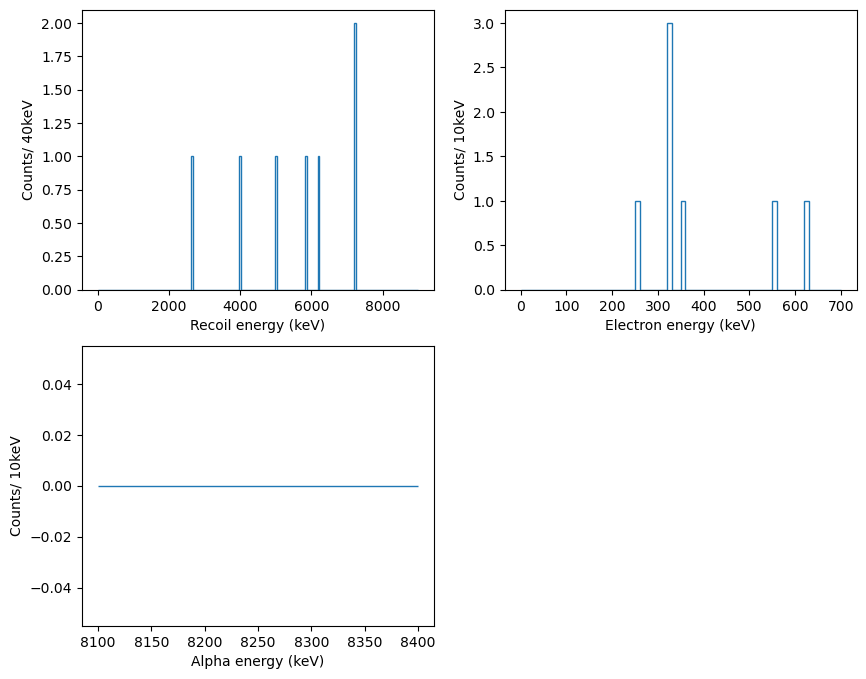

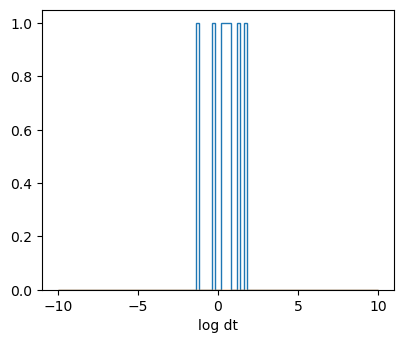

In [4]:
# Inspect
df = data["final_correlated"]
df_REA = df[df["chain"] == "REA"]
display(df_REA)
print(len(df_REA))

# plotting
# Plotting

if len(df_REA) >0:
    
    # Energies
    plt.figure(figsize=(10,8))
    plt.subplot(221)
    plt.hist(df_REA['recoil_xE'], histtype='step',bins=175, range=(0,9000))
    plt.xlabel('Recoil energy (keV)')
    plt.ylabel(r'Counts/ 40keV')
    plt.subplot(222)
    plt.hist(df_REA['electron_xE'], histtype='step',bins=70, range=(0,700))
    plt.xlabel('Electron energy (keV)')
    plt.ylabel(r'Counts/ 10keV')
    plt.subplot(223)
    plt.hist(df_REA['alpha_xE'], histtype='step', bins=60, range=(8100,8400))
    plt.xlabel('Alpha energy (keV)')
    plt.ylabel(r'Counts/ 10keV')
    plt.show()
    plt.close()
    
    # KHS plots 
    plt.figure(figsize=(10,8))
    plt.subplot(221)
    plt.hist(np.log(np.abs(df_REA['electron_t']-df_REA[r'recoil_t'])), histtype='step', bins =100, range=(-10,10))
    plt.xlabel('log dt')
    plt.subplot(221)
    plt.hist(np.log(np.abs(df_REA['alpha_t']-df_REA[r'recoil_t'])), histtype='step', bins =100, range=(-10,10))

# RE

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha1_x,alpha1_y,alpha1_t,alpha1_xE,alpha1_dt,alpha2_x,alpha2_y,alpha2_t,alpha2_xE,alpha2_dt
353,32.0,53.0,5826.856459,3.027000e+12,3.026999e+12,4402.0,3.026999e+12,1148.0,3.026999e+12,1683.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354,29.0,48.0,6976.169584,1.073609e+13,1.073609e+13,4015.0,1.073609e+13,888.0,1.073609e+13,1731.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355,91.0,29.0,2105.129288,1.713478e+13,1.713478e+13,2730.0,1.713478e+13,815.0,1.713478e+13,638.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356,16.0,6.0,7178.996505,2.542620e+13,2.542620e+13,1924.0,2.542620e+13,557.0,2.542620e+13,364.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357,11.0,25.0,4345.555420,4.293780e+13,4.293780e+13,2893.0,4.293780e+13,907.0,4.293780e+13,709.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449,26.0,1.0,2138.176266,1.078359e+16,1.078359e+16,1970.0,1.078359e+16,464.0,1.078359e+16,425.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3450,117.0,30.0,5948.873079,1.078750e+16,1.078750e+16,3577.0,1.078750e+16,834.0,1.078750e+16,1309.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3451,19.0,57.0,2315.594289,1.079669e+16,1.079669e+16,1061.0,1.079669e+16,311.0,1.079669e+16,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3452,63.0,36.0,4987.478404,1.080492e+16,1.080492e+16,3077.0,1.080492e+16,754.0,1.080492e+16,863.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2645


Text(0, 0.5, 'Counts/ 10keV')

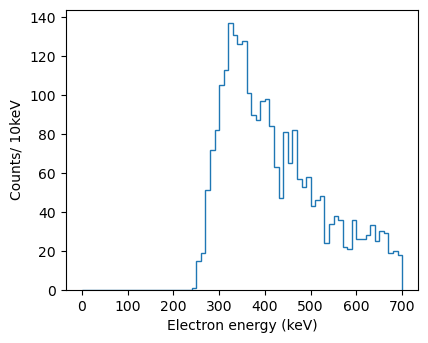

In [5]:
df = data["final_correlated"]
df_RE = df[df["chain"] == "RE"]
display(df_RE)
print(len(df_RE))
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_RE['electron_xE'], histtype='step',bins=70, range=(0,700))
plt.xlabel('Electron energy (keV)')
plt.ylabel(r'Counts/ 10keV')

# RA

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha1_x,alpha1_y,alpha1_t,alpha1_xE,alpha1_dt,alpha2_x,alpha2_y,alpha2_t,alpha2_xE,alpha2_dt
0,35.0,15.0,6862.952065,6.046224e+13,6.046224e+13,4042.0,6.046224e+13,920.0,6.046224e+13,1389.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,87.0,26.0,4388.934390,9.344928e+13,9.344928e+13,3863.0,9.344928e+13,1198.0,9.344928e+13,1062.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15.0,9.0,6385.057232,9.992233e+13,9.992233e+13,3248.0,9.992233e+13,773.0,9.992233e+13,1004.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68.0,10.0,5916.498072,1.458216e+14,1.458216e+14,3145.0,1.458216e+14,1277.0,1.458216e+14,526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,68.0,9.0,5916.498072,1.458216e+14,1.458216e+14,3145.0,1.458216e+14,1277.0,1.458216e+14,526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,45.0,26.0,6433.190617,1.790998e+14,1.790998e+14,3401.0,1.790998e+14,1492.0,1.790998e+14,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,45.0,27.0,6433.190617,1.790998e+14,1.790998e+14,3401.0,1.790998e+14,1492.0,1.790998e+14,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,68.0,46.0,6159.715391,1.827749e+14,1.827749e+14,3455.0,1.827749e+14,943.0,1.827749e+14,1012.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,68.0,47.0,6159.715391,1.827749e+14,1.827749e+14,3455.0,1.827749e+14,943.0,1.827749e+14,1012.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


698


Text(0, 0.5, 'Counts/ 40keV')

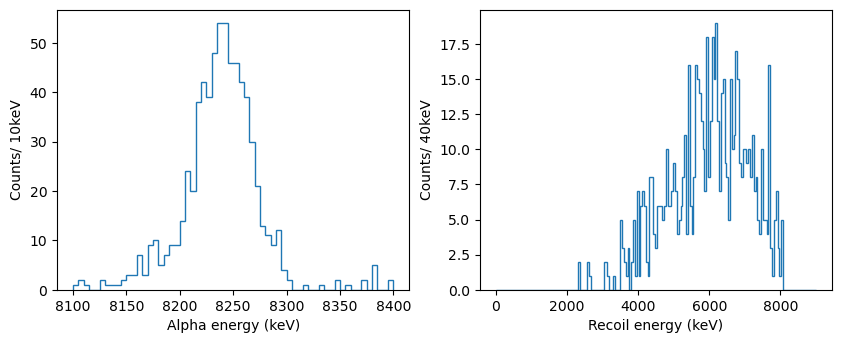

In [19]:
df = data["final_correlated"]
df_RA = df[df["chain"] == "RA"]
display(df_RA.iloc[:9])
print(len(df_RA))
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_RA['alpha_xE'], histtype='step', bins=60, range=(8100,8400))
plt.xlabel('Alpha energy (keV)')
plt.ylabel(r'Counts/ 10keV')

plt.subplot(222)
plt.hist(df_RA['recoil_xE'], histtype='step',bins=175, range=(0,9000))
plt.xlabel('Recoil energy (keV)')
plt.ylabel(r'Counts/ 40keV')

# RAA

In [8]:
df_RAA = df[df['chain']=='RAA']
display(df_RAA)

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha1_x,alpha1_y,alpha1_t,alpha1_xE,alpha1_dt,alpha2_x,alpha2_y,alpha2_t,alpha2_xE,alpha2_dt
1717,87.0,26.0,4388.934390,9.344928e+13,9.344928e+13,3863.0,9.344928e+13,1198.0,9.344928e+13,1062.0,...,87.0,26.0,97.735318,8256.997735,4.286037,87.0,26.0,620.432206,7424.151619,522.696887
1718,68.0,10.0,5916.498072,1.458216e+14,1.458216e+14,3145.0,1.458216e+14,1277.0,1.458216e+14,526.0,...,68.0,10.0,146.771431,8253.757190,0.949802,68.0,10.0,286.941902,7419.304273,140.170470
1719,68.0,9.0,5916.498072,1.458216e+14,1.458216e+14,3145.0,1.458216e+14,1277.0,1.458216e+14,526.0,...,68.0,9.0,146.771431,8253.757190,0.949802,68.0,9.0,286.941902,7419.304273,140.170470
1720,45.0,26.0,6433.190617,1.790998e+14,1.790998e+14,3401.0,1.790998e+14,1492.0,1.790998e+14,443.0,...,45.0,26.0,180.322734,8232.514426,1.222936,45.0,26.0,642.955640,7411.213371,462.632906
1721,68.0,46.0,6159.715391,1.827749e+14,1.827749e+14,3455.0,1.827749e+14,943.0,1.827749e+14,1012.0,...,68.0,46.0,184.116409,8247.825061,1.341534,68.0,46.0,391.560428,7407.440014,207.444019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3564,138.0,28.0,6051.866169,1.031807e+16,1.031807e+16,4728.0,1.031807e+16,1804.0,1.031807e+16,1172.0,...,138.0,28.0,10321.756010,8261.936655,3.690619,138.0,28.0,10427.046634,7427.110760,105.290624
3565,138.0,27.0,6051.866169,1.031807e+16,1.031807e+16,4728.0,1.031807e+16,1804.0,1.031807e+16,1172.0,...,138.0,27.0,10321.756010,8261.936655,3.690619,138.0,27.0,10427.046634,7427.110760,105.290624
3566,87.0,6.0,7416.200821,1.032178e+16,1.032178e+16,3383.0,1.032178e+16,994.0,1.032178e+16,762.0,...,87.0,6.0,10323.218662,8251.034637,1.436019,87.0,6.0,10822.237236,7440.053216,499.018574
3567,86.0,31.0,5920.675910,1.035980e+16,1.035980e+16,4620.0,1.035980e+16,1932.0,1.035980e+16,945.0,...,86.0,31.0,10361.733412,8217.923160,1.934108,86.0,31.0,10403.802866,7411.104489,42.069455


Text(0, 0.5, 'Counts/ 10keV')

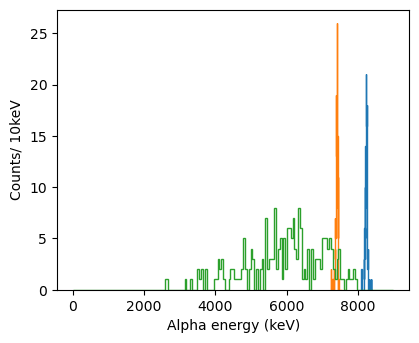

In [11]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_RAA['alpha1_xE'], histtype='step', bins=60, range=(8100,8400))
plt.hist(df_RAA['alpha2_xE'], histtype='step', bins=60, range=(7250,7550))
plt.hist(df_RAA['recoil_xE'], histtype='step',bins=175, range=(0,9000))
plt.xlabel('Alpha energy (keV)')
plt.ylabel(r'Counts/ 10keV')

# REAA

In [13]:
df_REAA = df[df['chain']=='REAA']
display(df_REAA)

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha1_x,alpha1_y,alpha1_t,alpha1_xE,alpha1_dt,alpha2_x,alpha2_y,alpha2_t,alpha2_xE,alpha2_dt
1823,112.0,47.0,5849.625614,4.851960e+15,4.851960e+15,4062.0,4.851960e+15,1762.0,4.851960e+15,620.0,...,112.0,47.0,4855.255781,8273.664825,1.809274,112.0,47.0,5530.836028,7440.149681,675.580246
3569,51.0,30.0,2660.819644,5.545781e+15,5.545781e+15,2419.0,5.545781e+15,1325.0,5.545781e+15,97.0,...,51.0,30.0,5548.364537,8219.685524,0.671410,51.0,30.0,5855.397362,7356.965479,307.032825
3570,51.0,30.0,4997.934224,5.547434e+15,5.547434e+15,2973.0,5.547434e+15,1179.0,5.547434e+15,402.0,...,51.0,30.0,5548.364537,8219.685524,0.671410,51.0,30.0,5855.397362,7356.965479,307.032825


Text(0, 0.5, 'Counts/ 10keV')

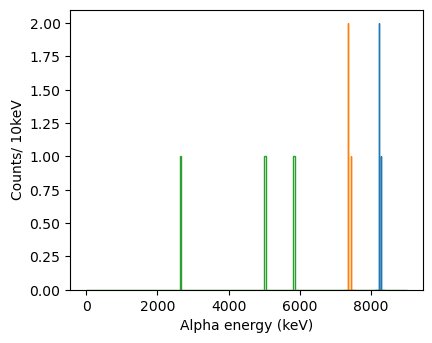

In [14]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_REAA['alpha1_xE'], histtype='step', bins=60, range=(8100,8400))
plt.hist(df_REAA['alpha2_xE'], histtype='step', bins=60, range=(7250,7550))
plt.hist(df_REAA['recoil_xE'], histtype='step',bins=175, range=(0,9000))
plt.xlabel('Alpha energy (keV)')
plt.ylabel(r'Counts/ 10keV')